# A file to create and combine ideas to be written up into functions

In [1]:
import numpy as np
import pyFAI
import matplotlib.pyplot as plt
import time
import collections
import yaml
import tifffile as tif

import functions as f
from functions import hexrd_rotation_matrix

In [2]:
with open("Configuration.yml", 'r') as ymlfile:
    output = f.read_hexrd(ymlfile)
    print(output)

{'energy': 18.0, 'VAREX1': {'location': array([ 160., -250., -170.]), 'rotation': array([ 0.        , -0.78539816,  0.        ]), 'detector_shape': array([2880., 2880.]), 'pixel_size': array([0.15, 0.15])}, 'VAREX2': {'location': array([ 160.,  250., -170.]), 'rotation': array([ 0.        , -0.78539816,  0.        ]), 'detector_shape': array([2880., 2880.]), 'pixel_size': array([0.15, 0.15])}}


#### pyFAI rotation matrix
$$\mathbf{R_3}\left(\theta_3\right) \; \; \mathbf{R_2}\left(\theta_2\right) \; \;  \mathbf{R_1}\left(\theta_1\right) = \begin{bmatrix} \cos \theta_3 & -\sin \theta_3 & 0 \\ \sin \theta_3 & \cos \theta_3 & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \cos \theta_2 & 0 & -\sin \theta_2 \\ 0 & 1 & 0 \\ \sin \theta_2 & 0 & \cos \theta_2 \end{bmatrix} \begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos \theta_1 & \sin \theta_1 \\ 0 & -\sin \theta_1 & \cos \theta_1 \end{bmatrix} =
\begin{bmatrix} \cos \theta_3 \cos \theta_2 & \cos \theta_3 \sin \theta_2 \sin \theta_1 - \sin \theta_3 \cos \theta_1 & -\cos \theta_3 \sin \theta_2 \cos \theta_1 - \sin \theta_3 \sin \theta_1 \\ \sin \theta_3 \cos \theta_2 & \sin \theta_3 \sin \theta_2 \sin \theta_1 + \cos \theta_3 \cos \theta_1 & -\sin \theta_3 \sin \theta_2 \cos \theta_1 + \cos \theta_3 \sin \theta_1 \\ \sin \theta_2 & -\cos \theta_2 \sin \theta_1 & \cos \theta_2 \cos \theta_1 \end{bmatrix}$$

In [3]:
distance, poni1, poni2, theta1, theta2, theta3 = f.hexrd_to_pyfai_params(output)

#### heXRD rotation matrix
$$\mathbf{R_Z}\left(\theta_Z\right) \; \; \mathbf{R_Y}\left(\theta_Y\right) \; \;  \mathbf{R_X}\left(\theta_X\right) = \begin{bmatrix} \cos \theta_Z & -\sin \theta_Z & 0 \\ \sin \theta_Z & \cos \theta_Z & 0 \\ 0 & 0 & 1 \end{bmatrix} \begin{bmatrix} \cos \theta_Y & 0 & \sin \theta_Y \\ 0 & 1 & 0 \\ -\sin \theta_Y & 0 & \cos \theta_Y \end{bmatrix} \begin{bmatrix} 1 & 0 & 0 \\ 0 & \cos \theta_X & -\sin \theta_X \\ 0 & \sin \theta_X & \cos \theta_X \end{bmatrix} =
\begin{bmatrix} \cos \theta_Z \cos \theta_Y & \cos \theta_Z \sin \theta_Y \sin \theta_X - \sin \theta_Z \cos \theta_X & \cos \theta_Z \sin \theta_Y \cos \theta_X + \sin \theta_Z \sin \theta_X \\ \sin \theta_Z \cos \theta_Y & \sin \theta_Z \sin \theta_Y \sin \theta_X + \cos \theta_Z \cos \theta_X & \sin \theta_Z \sin \theta_Y \cos \theta_X - \cos \theta_Z \sin \theta_X \\ -\sin \theta_Y & \cos \theta_Y \sin \theta_X & \cos \theta_Y \cos \theta_X \end{bmatrix}$$


In [5]:
print(f.pyfai_to_hexrd_params(distance, poni1, poni2, theta1, theta2, theta3, detector_shape=[2880, 2880], pixel_size=[150e-6,150e-6]))

(array([ 160., -250., -170.]), array([ 0.        , -0.78539817,  0.        ]))


In [6]:
# with open('test.poni', 'w') as ponifile:
#     for detector_num in len(list(output.keys()))-1:
#         name = list(output.keys())[detector_num+1]
#         _ = output[name]
#         f.write_poni(ponifile, name, _['pixel_size'][0], _['pixel_size'][1], _['detector_shape'], _[])

In [7]:
def detectors_to_common_plane():#PONI1, PONI2):
    distance_1, poni1_1, poni2_1, theta1_1, theta2_1, theta3_1 = 0.222, 0.4602, 0.2177, 0.7900, 0.0096, 1.6e-5 #PONI_to_params(PONI1)
    distance_2, poni1_2, poni2_2, theta1_2, theta2_2, theta3_2 = 0.2236, -0.0227, 0.2175, 0.7892, -0.0141, 5.0e-5#PONI_to_params(PONI2)
    
    rotation_matrix_1 = f.pyfai_rotation_matrix(theta1_1, theta2_1, theta3_1)
    rotation_matrix_2 = f.pyfai_rotation_matrix(theta1_2, theta2_2, theta3_2)
    
    number_of_pixels = 2880
    pixel_size = 150e-6
    half_detector_width = number_of_pixels*pixel_size / 2
    
    centre_1_un_rotated = np.array([-poni1_1 + half_detector_width, -poni2_1 + half_detector_width, distance_1])
    centre_1 = np.dot(rotation_matrix_1, centre_1_un_rotated)
    centre_2_un_rotated = np.array([-poni1_2 + half_detector_width, -poni2_2 + half_detector_width, distance_2])
    centre_2 = np.dot(rotation_matrix_2, centre_2_un_rotated)
    
    side_1_un_rotated = np.array([-poni1_1 + half_detector_width, -poni2_1, distance_1])
    side_1 = np.dot(rotation_matrix_1, side_1_un_rotated)
    side_2_un_rotated = np.array([-poni1_2 + half_detector_width, -poni2_2, distance_2])
    side_2 = np.dot(rotation_matrix_2, side_2_un_rotated)
    side_average = (side_1+side_2)/2
    
    plane_normal = np.cross(centre_2 - side_average, centre_1 - side_average) / np.linalg.norm(np.cross(centre_1 - side_average, centre_2 - side_average))
    fake_distance = np.dot(plane_normal, centre_1)
    poni_coords = plane_normal*fake_distance
    return plane_normal, np.array([centre_1, centre_2, poni_coords])

In [8]:
normal, points = detectors_to_common_plane()

In [100]:
def project_detector(plane_normal, plane_coord_1, plane_coord_2, plane_poni):
    # Sample the outer ring of a detector and find the coordinates -> project these onto the new detector plane -> plot
    distance_1, poni1_1, poni2_1, theta1_1, theta2_1, theta3_1 = 0.222, 0.4602, 0.2177, 0.7900, 0.0096, 1.6e-5 #PONI_to_params(PONI1)
    distance_2, poni1_2, poni2_2, theta1_2, theta2_2, theta3_2 = 0.2236, -0.0227, 0.2175, 0.7892, -0.0141, 5.0e-5#PONI_to_params(PONI2)
    
    rotation_matrix_1 = f.pyfai_rotation_matrix(theta1_1, theta2_1, theta3_1)
    rotation_matrix_2 = f.pyfai_rotation_matrix(theta1_2, theta2_2, theta3_2)
    
    number_of_pixels = 2880
    pixel_size = 150e-6
    
    coord_det_1 = f.get_coords(pixel_size, number_of_pixels, poni1_1, poni2_1, distance_1, rotation_matrix_1)
    coord_det_2 = f.get_coords(pixel_size, number_of_pixels, poni1_2, poni2_2, distance_2, rotation_matrix_2)
    
    coord_det_all = np.hstack((coord_det_1, coord_det_2))
    
    t_ = sum(plane_normal * plane_coord_1) / (plane_normal[0]*coord_det_all[0, :] + plane_normal[1]*coord_det_all[1, :] + plane_normal[2]*coord_det_all[2, :])
    
    coord_det_projection = np.vstack((coord_det_all[0, :]*t_, coord_det_all[1, :]*t_, coord_det_all[2, :]*t_))
    
    origin_ = np.vstack((np.zeros_like(coord_det_all[0, :]) + plane_poni[0], np.zeros_like(coord_det_all[0, :]) + plane_poni[1], np.zeros_like(coord_det_all[0, :]) + plane_poni[2]))
    
    projection_translated = coord_det_projection - origin_
    coord_vector_1 = (plane_coord_2 - plane_coord_1) / np.linalg.norm(plane_coord_2 - plane_coord_1)
    coord_vector_2 = np.cross(coord_vector_1, plane_normal)
    
    coords1 = np.dot(coord_vector_1, projection_translated)
    coords2 = np.dot(coord_vector_2, projection_translated)
    return coords1, coords2, coord_det_projection, coord_det_all

In [101]:
def area4(a0, a1, b0, b1, c0, c1, d0, d1):
    return 0.5 * (((c0-a0) * (d1-b1)) - ((c1-a1) * (d0-b0)))

In [102]:
x, y, projection, detectors = project_detector(normal, points[0], points[1], points[2])

In [105]:
VAREX1_c = np.array(tif.imread('V1_preshot-r0728.tiff')).ravel()
VAREX2_c = np.array(np.rot90(np.rot90(tif.imread('V2_preshot-r0728.tiff')))).ravel()

all_c = np.hstack((VAREX1_c, VAREX2_c))
C = np.log10(all_c[::50])

C:\Users\tomst\AppData\Local\Temp\ipykernel_22136\844405173.py:5: RuntimeWarning: divide by zero encountered in log10
  C = np.log10(all_c[::50])
C:\Users\tomst\AppData\Local\Temp\ipykernel_22136\844405173.py:5: RuntimeWarning: invalid value encountered in log10
  C = np.log10(all_c[::50])


Text(0.5, 1.0, 'Projection of VAREX pixels onto the common plane')

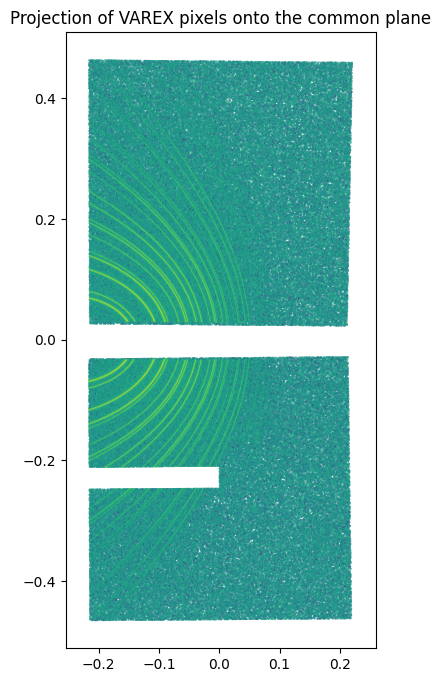

In [113]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot()

ax.axis('equal')
ax.scatter(-y[::50], x[::50], s=0.1, c = C)
ax.set_title('Projection of VAREX pixels onto the common plane')

(-0.1, 0.2)

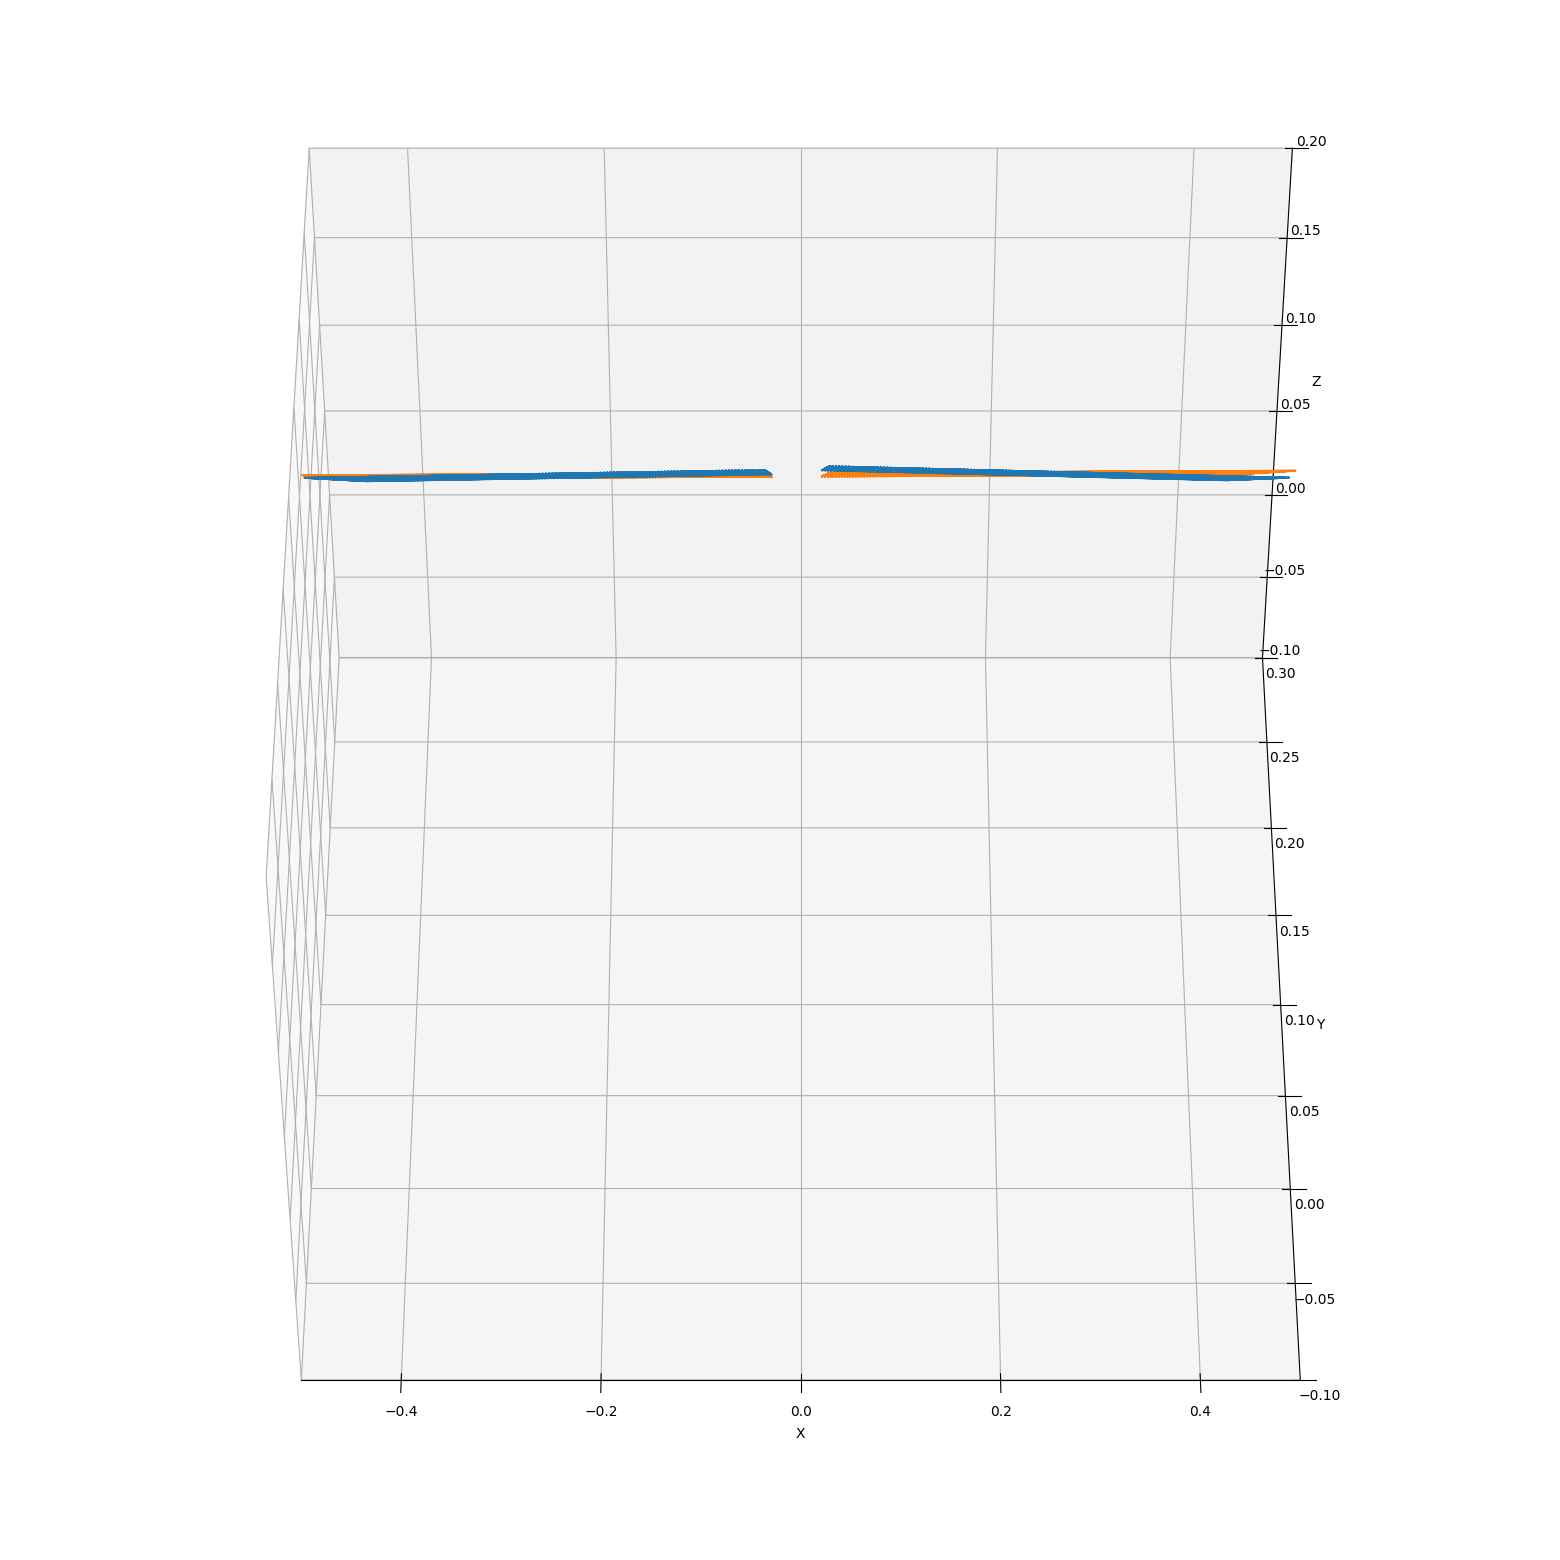

In [58]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(projection='3d')

ax.axis('equal')
ax.scatter(detectors[0, ::100], detectors[1, ::100], detectors[2, ::100], s = 0.1)
ax.scatter(projection[0, ::100], projection[1, ::100], projection[2, ::100], s = 0.1, alpha = 1)
ax.view_init(elev=47, azim=-90)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.axes.set_xlim3d(left=-0.5, right=0.5)
ax.axes.set_ylim3d(bottom=-0.1, top=0.3)
ax.axes.set_zlim3d(bottom=-0.1, top=0.2)